<a href="https://colab.research.google.com/github/rev-an/rev-an/blob/main/image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm
import tensorflow as tf

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.utils import to_categorical, plot_model
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
import matplotlib.pyplot as plt
import re
import joblib
warnings.filterwarnings('ignore')

In [ ]:
!unzip /content/Flicker8k_Dataset.zip -d /content/flicker8k

Streaming output truncated to the last 5000 lines.
 extracting: /content/flicker8k/1650280501_29810b46e5.jpg  
 extracting: /content/flicker8k/2052953131_30834196fb.jpg  
 extracting: /content/flicker8k/2083778090_3aecaa11cc.jpg  
 extracting: /content/flicker8k/2089555297_95cf001fa7.jpg  
 extracting: /content/flicker8k/2195887578_3ba2f29b48.jpg  
 extracting: /content/flicker8k/2230067846_74046b89d3.jpg  
 extracting: /content/flicker8k/2264316030_600e55748d.jpg  
 extracting: /content/flicker8k/2271671533_7538ccd556.jpg  
 extracting: /content/flicker8k/2420730259_86e7f8a815.jpg  
 extracting: /content/flicker8k/2602085456_d1beebcb29.jpg  
 extracting: /content/flicker8k/2687672606_275169c35d.jpg  
 extracting: /content/flicker8k/2750867389_4b815f793a.jpg  
 extracting: /content/flicker8k/2751694538_fffa3d307d.jpg  
 extracting: /content/flicker8k/2809793070_1a3387cd6e.jpg  
 extracting: /content/flicker8k/2871962580_b85ce502ba.jpg  
 extracting: /content/flicker8k/2929272606_2a5923

In [ ]:
!unzip /content/Flickr8k_text.zip -d /content/flicker8k_text

Archive:  /content/Flickr8k_text.zip
mapname:  conversion of  failed
 extracting: /content/flicker8k_text/readme.txt  
 extracting: /content/flicker8k_text/Flickr8k.token.txt  
 extracting: /content/flicker8k_text/ExpertAnnotations.txt  
 extracting: /content/flicker8k_text/Flickr_8k.devImages.txt  
 extracting: /content/flicker8k_text/Flickr_8k.testImages.txt  
 extracting: /content/flicker8k_text/Flickr8k.lemma.token.txt  
 extracting: /content/flicker8k_text/Flickr_8k.trainImages.txt  
 extracting: /content/flicker8k_text/CrowdFlowerAnnotations.txt  


In [ ]:
# Directory setup
base_img_dir = '/content/flicker8k'
base_txt_dir = '/content/flicker8k_text'
working_dir = '/content/dir_w'
os.makedirs(working_dir, exist_ok=True)

In [ ]:
# Load pre-trained VGG16 model
def load_vgg16_model():
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    return model

model = load_vgg16_model()
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Feature extraction
def extract_image_features(directory, model):
    features = {}
    for img_name in tqdm(os.listdir(directory)):
        img_path = os.path.join(directory, img_name)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = img_name.split('.')[0]
        features[image_id] = feature
    return features

features = extract_image_features(base_img_dir, model)

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
# Save features
joblib.dump(features, os.path.join(working_dir, 'features.pkl'))

['/content/dir_w/features.pkl']

In [ ]:
# Load captions
def load_captions(file_path):
    with open(file_path, 'r') as f:
        captions = f.read()
    return captions

In [ ]:
captions = load_captions(os.path.join(base_txt_dir, 'Flickr8k.lemma.token.txt'))

In [ ]:
#map captions to images
def map_captions_to_images(captions):
    mapping = {}
    for line in tqdm(captions.split('\n')):
        tokens = line.split('\t')
        if len(tokens) < 2:
            continue
        image_id, caption = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        caption = " ".join(caption)
        if image_id not in mapping:
            mapping[image_id] = []
        mapping[image_id].append(caption)
    return mapping

mapping = map_captions_to_images(captions)

  0%|          | 0/40461 [00:00<?, ?it/s]

In [ ]:
# Clean captions
def clean_caption(caption):
    caption = caption.lower()
    caption = re.sub(r'[^a-z\s]', '', caption)
    caption = re.sub(r'\s+', ' ', caption)
    caption = 'start ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' end'
    return caption

In [ ]:
def clean_mapping(mapping):
    for key, captions in mapping.items():
        mapping[key] = [clean_caption(caption) for caption in captions]

clean_mapping(mapping)

In [ ]:
#Prepare tokenization
all_captions = [caption for captions in mapping.values() for caption in captions]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)


In [ ]:
# Train-test split
image_ids = list(features.keys())
split = int(len(image_ids) * 0.9)
train_ids = image_ids[:split]
test_ids = image_ids[split:]

In [ ]:
# Data generator for training
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []
    n = 0
    while True:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                yield np.array(X1), np.array(X2), np.array(y)
                X1, X2, y = [], [], []
                n = 0

In [ ]:
# Model definition
def create_model(vocab_size, max_length):
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.4)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.4)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    plot_model(model, show_shapes=True)
    return model

model = create_model(vocab_size, max_length)

In [ ]:
# Training loop
epochs = 30
batch_size = 64
steps = len(train_ids) // batch_size

# Move model compilation outside the loop
model.compile(loss='categorical_crossentropy', optimizer='adam')  # Compile only once

for epoch in range(epochs):
    generator = data_generator(train_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    for _ in range(steps):
        # Get a single batch from the generator
        X1, X2, y = next(generator)

        # Train the model on the batch
        model.fit([X1, X2], y, epochs=1, batch_size=batch_size, verbose=1)

50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 366ms/step - loss: 6.8738
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 262ms/step - loss: 5.7349
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 264ms/step - loss: 5.4671
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 264ms/step - loss: 5.5025
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 265ms/step - loss: 5.2417
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 264ms/step - loss: 5.1576
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 263ms/step - loss: 4.9398
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 266ms/step - loss: 4.9182
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 265ms/step - loss: 4.8817
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 266ms/step - loss: 4.6837
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 265ms/step - loss: 4.8888
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 286ms/step - loss: 4.8391
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 270ms/step - loss: 4.7433
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 273ms/step - loss: 4.8250
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - loss: 4.6267
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 288ms/step - loss: 4.4890
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - loss: 4.4974
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 

KeyboardInterrupt: 

In [ ]:
# Save the model
model.save(os.path.join(working_dir, 'best_model.h5'))

In [ ]:
# Caption prediction function
def idx_to_word(index, tokenizer):
    return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

In [ ]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'start'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None or word == 'end':
            break
        in_text += " " + word
    return in_text

In [ ]:
# BLEU score evaluation
def evaluate_bleu_score(test_ids, mapping, features, tokenizer, max_length):
    actual, predicted = [], []
    for key in tqdm(test_ids):
        caps = mapping[key]
        y_pred = predict_caption(model, features[key], tokenizer, max_length)
        actual_captions = [caption.split() for caption in caps]
        y_pred = y_pred.split()
        actual.append(actual_captions)
        predicted.append(y_pred)

    print(f"BLEU-1: {corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)):.4f}")
    print(f"BLEU-2: {corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)):.4f}")

evaluate_bleu_score(test_ids, mapping, features, tokenizer, max_length)

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.4972
BLEU-2: 0.3042


In [ ]:
# Generate caption for a new image
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(base_img_dir, image_name)
    image = Image.open(img_path)
    caption = predict_caption(model, features[image_id], tokenizer, max_length)
    print("Predicted Caption: ", caption)
    plt.imshow(image)

Predicted Caption:  start man in red shirt be stand on the snow


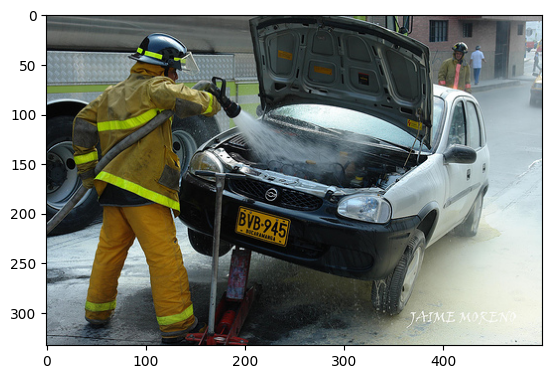

In [ ]:
generate_caption('1351764581_4d4fb1b40f.jpg')